

# Item based filtering
This approach is mostly preferred since the movie don't change much. We can rerun this model once a week unlike User based where we have to frequently run the model.

In this kernel, We look at the implementation of Item based filtering

In [2]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
#read the dataset
movies = pd.read_csv('data/movies.csv') #read csv file in data/movies.csv
ratings = pd.read_csv('data/ratings.csv') #read csv file in data/ratings.csv

In [4]:
#print the head of the ratings to see some of its features
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Ratings dataset has 
* userId - unique for each user
* movieId - using this feature ,we take the title of the movie from movies dataset
* rating - Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies

In [5]:
#print the head of the movies to see some of its features\
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Movie dataset has 
* movieId - once the recommendation is done, we get list of all similar movieId and get the title for each movie from this dataset. 
* genres -  which is not required for this filtering approach

In [6]:
#display the ratings from users per movies
#in other words, change the form of the table from what you saw in ratings.head()
#to something you could see as movie ratings per users
#so, transform the dataset of ratings to have the index as movieid.
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating') #Return reshaped DataFrame organized by given index / column / values.
final_dataset.head(20)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [8]:
# How should you handle missing values here?
#for now, just fill the NaN  as 0
final_dataset.fillna( 0 ,inplace=True)
final_dataset.head(20)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In a real world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. So we will reduce the noise by adding some filters and qualify the movies for the final dataset.
* To qualify a movie, minimum 10 users should have voted a movie.(popular movies)
* To qualify a user, minimum 50 movies should have voted by the user.(highly engaged users)


In [ ]:
# Count the Number of Users Who Voted for Each Movie:
# Group the DataFrame by movieId and count the number of ratings for each movie.

no_user_voted = ratings.groupby('movieId')['rating'].agg('count') #Aggregate using one or more operations over the specified axis.

In [10]:
no_user_voted

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [11]:
#Count the Number of Movies Each User Has Voted For:
#Group the DataFrame by userId and count the number of ratings each user has made.
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [12]:
no_movies_voted

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64

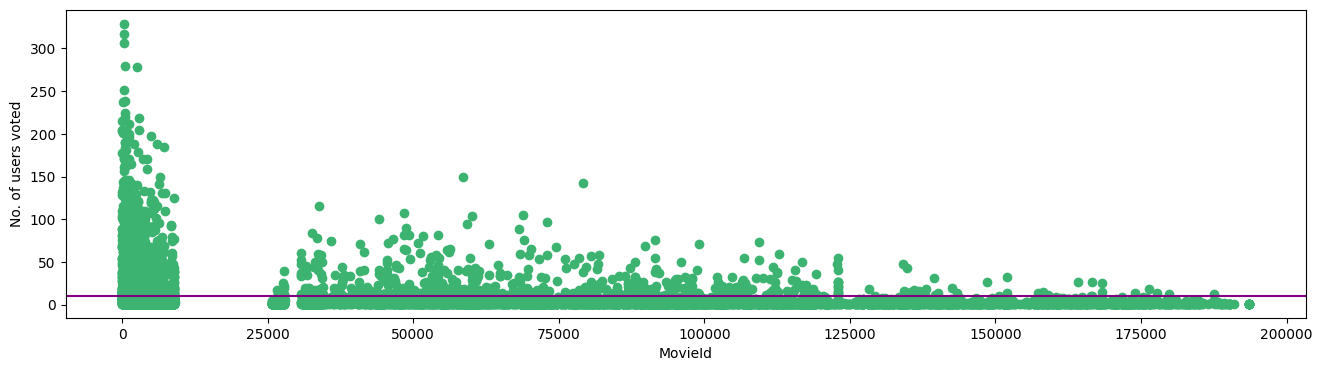

In [13]:
fig,ax = plt.subplots(figsize=(16,4))
plt.scatter(no_user_voted.index , no_user_voted ,color='mediumseagreen') #scatter plot the number of users voted
plt.axhline(y=10,color='purple') #add this line as a threshold
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [14]:
#now keep the movies that where voted by more than 10 users.
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index , :]

In [15]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2121 entries, 1 to 187593
Columns: 610 entries, 1 to 610
dtypes: float64(610)
memory usage: 9.9 MB


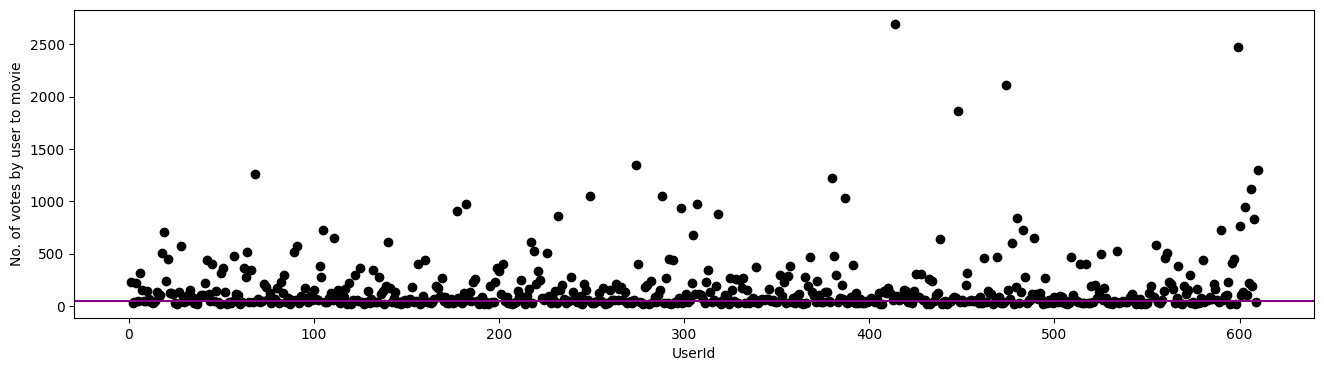

In [16]:
f,ax = plt.subplots(figsize=(16,4))
plt.scatter(no_movies_voted.index , no_movies_voted ,color='black') #scatter plot the number of movies 
plt.axhline(y=50,color='purple') #this is the threshold of movies voted from users that voted more than 50 movies
plt.xlabel('UserId')
plt.ylabel('No. of votes by user to movie')
plt.show()

In [17]:
#now keep only the movies that has users voting for minimum of 50 movies
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted>50].index ]
final_dataset 

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our final_dataset has dimensions of **2121 * 378** where most of the values are sparse. I took only small dataset but for
original large dataset of movie lens which has more than **100000** features, this will sure hang our system when this has 
feed to model. To reduce the sparsity we use csr_matric scipy lib. I'll give an example how it works

In [18]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [19]:
csr_sample = csr_matrix(sample) #csr_matrix : compression matrix
print(csr_sample)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4 stored elements and shape (3, 5)>
  Coords	Values
  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


* As you can see there is no sparse value in the csr_sample and values are assigned as rows and column index. for the 0th row and 2nd column , value is 3 . Look at the original dataset where the values at the right place. This is how it works using todense method you can take it back to original dataset.
* Most of the sklearn works with sparse matrix. surely this will improve our performance

In [20]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

We use cosine distance metric which is very fast and preferable than pearson coefficient. Please don't use euclidean distance which will not work when the values are equidistant.

In [21]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [22]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1) #n_jobs : key argament by default !! 
knn.fit(csr_data) #fit the sparse data

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# Application

In [23]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [24]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Avatar (2009),0.310893
2,Iron Man 2 (2010),0.307492
3,WALL·E (2008),0.298138
4,"Dark Knight, The (2008)",0.285835
5,"Avengers, The (2012)",0.285319


In [25]:
get_movie_recommendation('Jumanji')

,Title,Distance
1,Aladdin (1992),0.425428
2,Jurassic Park (1993),0.420563
3,Mrs. Doubtfire (1993),0.416164
4,"Mask, The (1994)",0.413743
5,"Lion King, The (1994)",0.377013


Our model works perfectly predicting the recommendation based on user behaviour and past search. So we conclude our 
collaborative filtering here.


# Now using another model for clustering using KMeans clustering method!!

In [ ]:
#Option1: 
final_dataset.columns = final_dataset.columns.astype(str)
#Option2:
final_dataset = final_dataset.to_numpy()
#Explanation
#Option 1: This approach ensures that all column names are strings, which is required by scikit-learn's KMeans when feature names are present.
#Option 2: This approach removes the feature names entirely by converting the dataset to a NumPy array, which is also acceptable for KMeans.
#Choose the option that best fits your needs. If you need to keep track of feature names for interpretation or further analysis,
#Go with Option 1. If feature names are not important, Option 2 is simpler.

In [28]:
final_dataset.columns = final_dataset.columns.astype(str)

sil_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 10, 11, 14]

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_dataset)
    labels = kmeans.labels_
    sil_avg.append(silhouette_score(final_dataset, labels, metric='euclidean'))

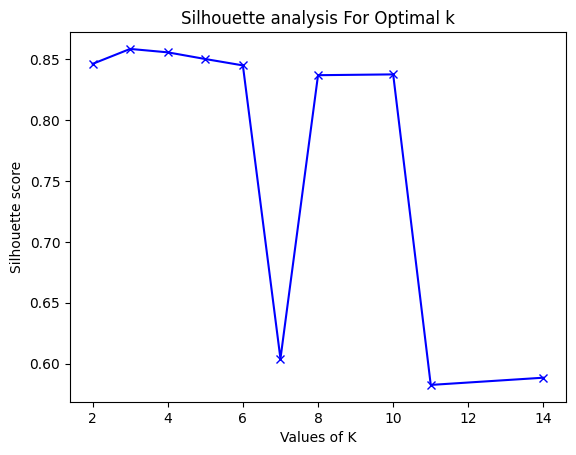

In [29]:
plt.plot(range_n_clusters, sil_avg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

# Chosing K =3!!

In [30]:
kmeans = KMeans(n_clusters = 3).fit(final_dataset)
labels = kmeans.labels_
sil_avg.append(silhouette_score(final_dataset, labels, metric = 'euclidean')) #todo: add other values for metric we can test

In [31]:
from sklearn.cluster import KMeans

def get_movie_recommendation_kmeans(movie_name, n_movies_to_recommend=5):
    # Find the movie in the dataset
    movie_list = movies[movies['title'].str.contains(movie_name, case=False)]  
    if len(movie_list):        
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        # Fit KMeans clustering
        kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
        kmeans.fit(final_dataset.drop(columns=['movieId']))  # Drop non-feature columns
        
        # Get the cluster label of the input movie
        input_movie_cluster = kmeans.labels_[movie_idx]
        
        # Find all movies in the same cluster
        cluster_movies = final_dataset[kmeans.labels_ == input_movie_cluster]
        
        # Exclude the input movie itself
        cluster_movies = cluster_movies[cluster_movies.index != movie_idx]
        
        # Sort movies by similarity (e.g., Euclidean distance to the input movie)
        input_movie_features = final_dataset.iloc[movie_idx].drop('movieId')
        cluster_movies['distance'] = cluster_movies.drop(columns=['movieId']).apply(
            lambda x: np.linalg.norm(x - input_movie_features), axis=1
        )
        cluster_movies = cluster_movies.sort_values(by='distance')
        
        # Get the top N recommendations
        top_recommendations = cluster_movies.head(n_movies_to_recommend)
        
        # Prepare the recommendation frame
        recommend_frame = []
        for idx, row in top_recommendations.iterrows():
            movie_id = row['movieId']
            movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
            recommend_frame.append({'Title': movie_title, 'Distance': row['distance']})
        
        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend + 1))
        return df
    
    else:
        return "No movies found. Please check your input"

In [32]:
get_movie_recommendation_kmeans('Jumanji')

,Title,Distance
1,Home Alone (1990),32.179186
2,Waterworld (1995),32.553802
3,"Santa Clause, The (1994)",32.832910
4,Addams Family Values (1993),33.018934
5,Batman Forever (1995),33.166248
